In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
plt.style.use('ggplot')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/WELFake_Dataset.csv')

In [4]:
df.sample(5)

,Unnamed: 0,title,text,label
69668,69668,DEMOCRAT CLERK Claims Election “Not Rigged” Bu...,"About 14,000 Genesee County voters were mailed...",1
43609,43609,American Airlines Throws Ivy League Economist...,Ivy League economist Guido Menzio has reported...,1
58279,58279,Ryan strikes conciliatory tone ahead of Trump ...,WASHINGTON (Reuters) - U.S. House Speaker Paul...,0
70587,70587,WWN’s Horoscopes,"Your workday goes into extra time, and you los...",1
28738,28738,5-YEAR OLD SUSPENDED FROM SCHOOL For Playing W...,The Hoke County School school system defended ...,1


In [5]:
df.shape

(72134, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [7]:
df.duplicated().sum()

0

In [8]:
df.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [9]:
df = df.dropna(subset=['title', 'text'])

In [10]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [11]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop(['title'], axis=1, inplace=True)
df.head(5)

<ipython-input-11-86a5de404f1a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Unnamed: 0'], axis=1, inplace=True)
<ipython-input-11-86a5de404f1a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['title'], axis=1, inplace=True)


,text,label
0,No comment is expected from Barack Obama Membe...,1
2,"Now, most of the demonstrators gathered last ...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,All we can say on this one is it s about time ...,1


In [12]:
df['label'].value_counts()

label
1    36509
0    35028
Name: count, dtype: int64

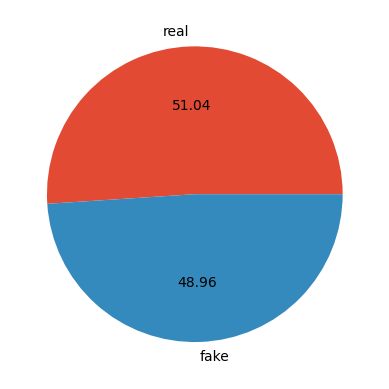

In [13]:
import matplotlib.pyplot as plt
plt.pie(df['label'].value_counts(), labels=['real','fake'],autopct="%0.2f")
plt.show()

0 for fake news, and 1 for real news

In [14]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    # Ensure the text is a string
    text = str(text)

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Lowercasing
    text = text.lower()

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

# Apply the preprocessing to the 'text' column
df['text'] = df['text'].apply(preprocess_text)

In [17]:
df.head(5)

,text,label
0,comment expected barack obama member fyf fukyo...,1
2,demonstrator gathered last night exercising co...,1
3,dozen politically active pastor came private d...,0
4,r sarmat missile dubbed satan replace s fly mi...,1
5,say one time someone sued southern poverty law...,1


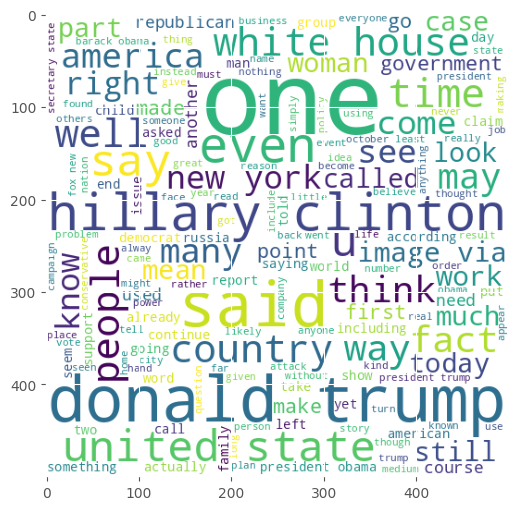

In [18]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
fake = wc.generate(df[df['label'] == 1]['text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(fake)

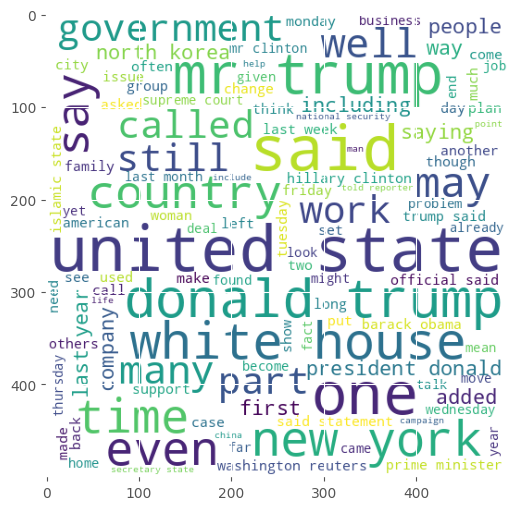

In [19]:
real = wc.generate(df[df['label'] == 0]['text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(real)

In [20]:
features = df['text']
targets = df['label']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [21]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [22]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [23]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5,validation_split=0.1, batch_size=30, shuffle=True)

Epoch 1/5
1717/1717 [==============================] - 137s 74ms/step - loss: 0.2862 - accuracy: 0.8751 - val_loss: 0.1485 - val_accuracy: 0.9469
Epoch 2/5
1717/1717 [==============================] - 78s 45ms/step - loss: 0.1184 - accuracy: 0.9603 - val_loss: 0.1371 - val_accuracy: 0.9416
Epoch 3/5
1717/1717 [==============================] - 73s 42ms/step - loss: 0.0744 - accuracy: 0.9771 - val_loss: 0.1256 - val_accuracy: 0.9553
Epoch 4/5
1717/1717 [==============================] - 73s 42ms/step - loss: 0.0513 - accuracy: 0.9854 - val_loss: 0.1529 - val_accuracy: 0.9581
Epoch 5/5
1717/1717 [==============================] - 71s 41ms/step - loss: 0.0329 - accuracy: 0.9913 - val_loss: 0.1474 - val_accuracy: 0.9602


In [26]:
model.evaluate(X_test, y_test)

448/448 [==============================] - 7s 16ms/step - loss: 0.1687 - accuracy: 0.9567


[0.16874440014362335, 0.9567375183105469]

In [27]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

448/448 [==============================] - 10s 17ms/step


In [28]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9567374895163545
Precision on testing set: 0.9605244996549345
Recall on testing set: 0.9543335161821174


In [29]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.3 MB/

In [30]:
import gradio as gr

In [31]:
def predict_news(text):
    processed_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post', maxlen=256)
    prediction = model.predict(padded_sequence)[0][0]
    return "Real" if prediction >= 0.5 else "Fake"

iface = gr.Interface(fn=predict_news,
                     inputs="text",
                     outputs="text",
                     title="Fake News Detection",
                     description="Enter the news text to check if it is fake or real.")

iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://faea42733cf9d2508e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
